In [73]:
import torch
import torch.nn as nn
from loader import prepare_data
from models.matrix_factorization import MatrixFactorizationModel
from models.neural_collab import NeuralCollaborativeModel
from models.wide_and_deep import WideAndDeepModel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [35]:
%matplotlib inline

In [7]:

# prepare the dataset
dataset, train_loader, validation_loader = prepare_data(
    ratings_path='../data/ml-25m/ratings.csv', batch_size=128
)

# load model from checkpoint
model = MatrixFactorizationModel.load_from_checkpoint(
    checkpoint_path='./ml-25m/1o8gw1zp/checkpoints/epoch=19-step=3125000.ckpt',
    n_users=dataset.num_users(),
    n_items=dataset.num_movies(),
    n_factors=50
)
model.eval()

MatrixFactorizationModel(
  (user_embeddings): Embedding(162542, 50)
  (movie_embeddings): Embedding(209172, 50)
  (user_bias): Embedding(162542, 1)
  (movie_bias): Embedding(209172, 1)
)

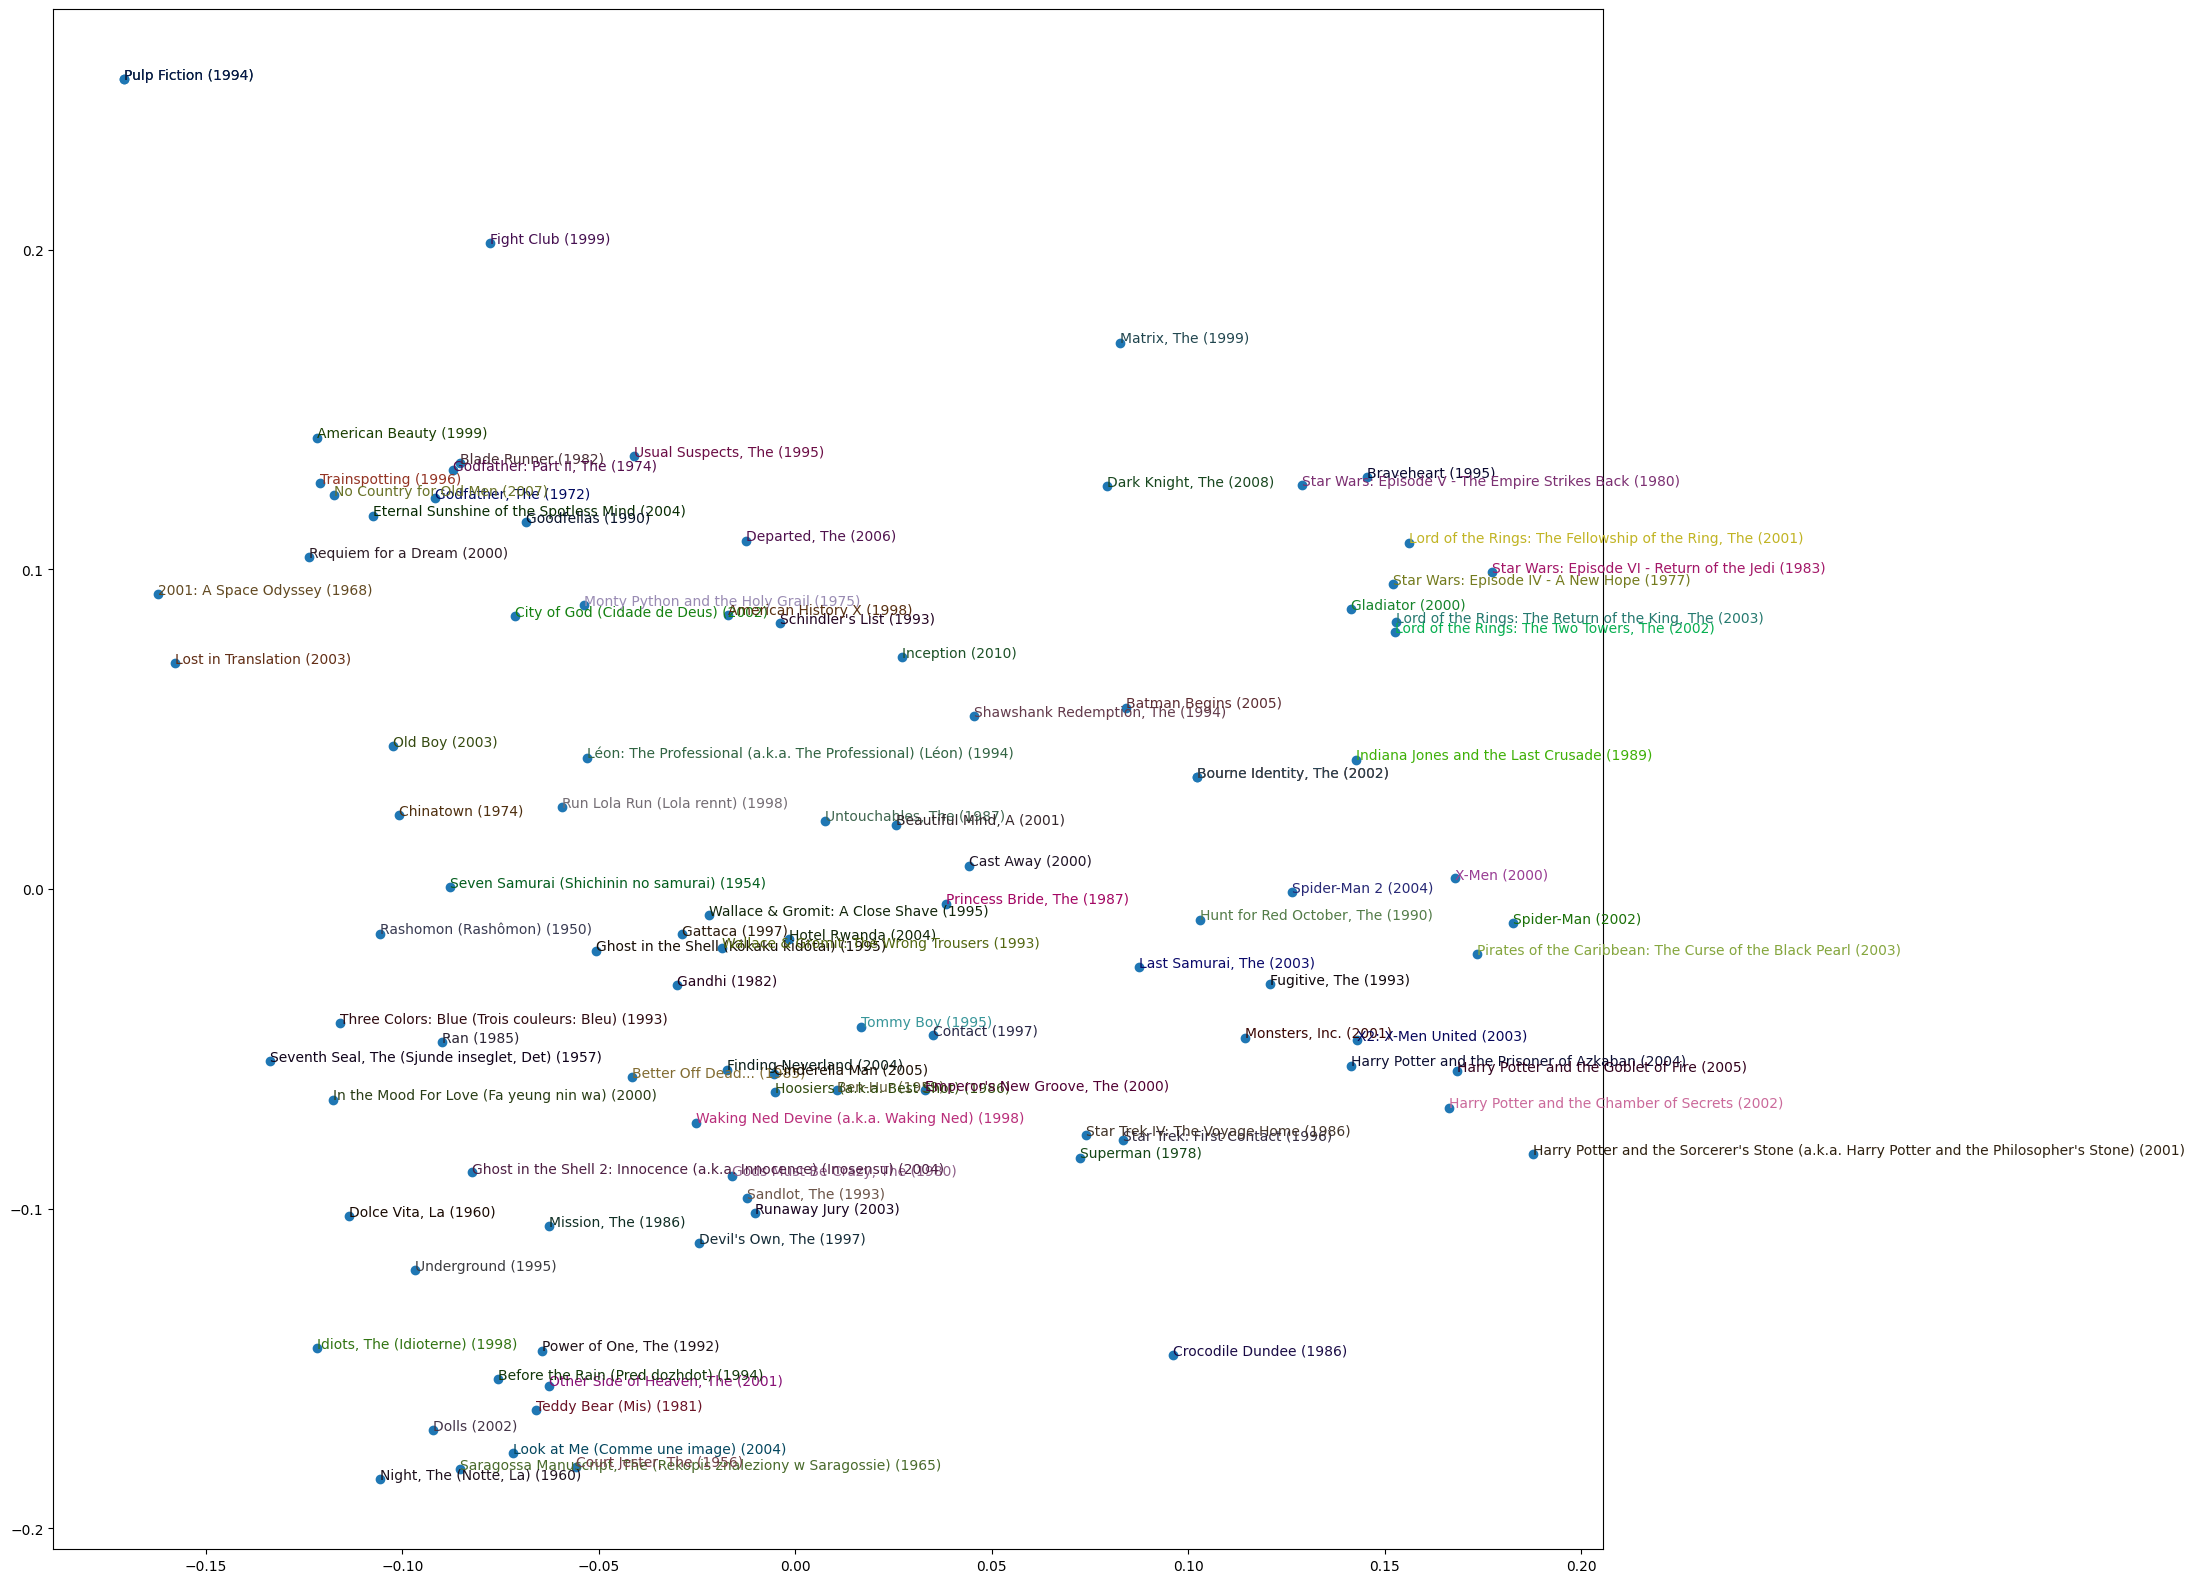

In [81]:
top_100 = dataset.df_ratings.nlargest(100, 'rating')['movieId'].tolist()
movies = pd.read_csv('../data/ml-25m/movies.csv')
titles = [movies.loc[movies['movieId'] == id]['title'].tolist()[0] for id in top_100]
genres = [movies.loc[movies['movieId'] == id]['genres'].tolist()[0] for id in top_100]
genres = [g.split('|') for g in genres]
genre_vocab = {s: i for i, s in enumerate(set([item for sublist in genres for item in sublist]))}


embeddings = model.movie_embeddings(torch.tensor(top_100, dtype=torch.long)).detach()
t = torch.pca_lowrank(embeddings, q=2)

X = t[0][:, 0]
Y = t[0][:, 1]

fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
ax.scatter(X, Y)

for i, (title, genre) in enumerate(zip(titles, genres)):
    color = np.random.rand(3) * np.mean([(genre_vocab[g] / len(genre_vocab)) for g in genre])
    ax.annotate(title, (X[i], Y[i]), color=color)